In [1]:
import requests
import re
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm_notebook
from urllib.parse import urlencode
import os
import zipfile
import calplot
import matplotlib.pyplot as plt

## Urls and Global Vars

In [10]:
# status
status_url = "http://www.aduanet.gob.pe/cl-ad-itsuministro/descargaS01Alias?accion=cargarFrmDescargarResultado"
# send request with params
request_url = "http://www.aduanet.gob.pe/cl-ad-itestdesp/SEGrabaReq"
# Download
download_url = "http://www.aduanet.gob.pe/cl-ad-itsuministro/descargaS01Alias"
# to not download constantly
keep_kv = False
kv_store = {}

## Get Status Page Records

In [3]:
def get_download_info(a_tag):
    pattern = r'\d+'
    numbers = re.findall(pattern, a_tag['href'])
    return {
        'file_name': numbers[0],
        'fecha': numbers[1],
        'hora': numbers[2]
    }
       
def parse_to_map(tr, index):
    td_with_a_tag = 6
    tds = tr.find_all('td')
    tds_text = [td.get_text(strip=True) for td in tds]
    tds_map = {f"td_{index}": value for index, value in enumerate(tds_text)}
    a_tag = tds[td_with_a_tag].find('a')
    if a_tag:
        tds_map['td_a_tag'] = get_download_info(a_tag)
    return tds_map
    
def get_status_all():
    if keep_kv and kv_store:
        return kv_store.values()
        
    tds_needed = 7
    html = b''
    response = requests.get(status_url, stream=True)
    total_size_in_bytes = int(response.headers.get('Content-length', 0))
    
    progress_bar = tqdm_notebook(total=total_size_in_bytes, unit='B', unit_scale=True, desc = "downloading html")
    
    for chunk in response.iter_content(chunk_size=1024):
        html+=chunk
        progress_bar.update(len(chunk))
    
    progress_bar.close()

    soup = BeautifulSoup(html, 'html.parser')
    trs = soup.find_all('tr')
    trs_filtered = [tr for tr in trs if len(tr.find_all('td')) == tds_needed]
    for index,tr in enumerate(trs_filtered):
        map = parse_to_map(tr, index)
        if keep_kv:
            kv_store[map['td_6']] = map
        yield map  

def get_status(id):
    id_full = f"{id}.ZIP"
    if keep_kv and id_full in kv_store:
        return kv_store[id_full]
    for status in get_status_all():
        if status['td_6'] == id_full :
            return status
    return None

## Send Request for an Interval

In [6]:
def send_request(code, start_date, end_date, type='Impo', format='E'):
    if type not in ('Impo', 'Expo'):
        raise ValueError('type not "Impo", "Expo" value')
    if format not in ('E', 'N', 'B'):
        raise ValueError('format not "E", "N", "B" value')
        
    params = {
        'ffin': end_date,
        'fini': start_date,
        'lcnan': code,
        'ltotaduana': 'T',
        'ltotpais': 'T',
        'regi': type,
        'tcon': format,
        'tipo': 'DBF'
    }
    encoded_params = urlencode(params)
    headers = {'Content-Type': 'application/x-www-form-urlencoded'}
    response = requests.post(request_url, data=encoded_params, headers=headers)
    if response.status_code == 200:
        print("extracting req id")
        soup = BeautifulSoup(response.text, 'html.parser')
        pattern = re.compile(r'\b(\d+)\.CON\b')
        matched_texts = soup.find_all(string=pattern)
        matched_numbers = [re.search(pattern, text).group(1) for text in matched_texts]
        if len(matched_numbers) > 0:
            return matched_numbers[0]
    else:
        print(f"error sending request: {reponse.status_code}")
    return None

In [8]:
request_id = send_request('8542310000', '01/01/2023', '30/06/2023', 'Impo', 'E')
request_id

extracting req id


'00410904'

## Check If finished

In [14]:
status = get_status(request_id)
status

downloading html: 0.00B [00:00, ?B/s]

{'td_0': '05/04/2024',
 'td_1': '05/04/2024',
 'td_2': '11:27:00',
 'td_3': '11:27:23',
 'td_4': 'Reporte',
 'td_5': '1923',
 'td_6': '00410904.ZIP',
 'td_a_tag': {'file_name': '00410904', 'fecha': '20240405', 'hora': '111451'}}

## Download and Extract File Generated

In [15]:
def download(id, destination):
    status = get_status(id)
    if status and int(status['td_5']) > 0:
        filename = status['td_6']
        params = {
            'accion': 'descargarArchivo',
            'filename': filename,
            'fregistro': status['td_a_tag']['fecha'],
            'hregistro': status['td_a_tag']['hora']
        }
        encoded_params = urlencode(params)
        headers = {'Content-Type': 'application/x-www-form-urlencoded'}
        response = requests.post(download_url, data=encoded_params, headers=headers)
        if response.status_code == 200:
            file_path = os.path.join(destination, filename)
            with open(file_path, 'wb') as f:
                f.write(response.content)
                print(f"File downloaded successfully: {file_path} ")
        else:
            print("Error occurred while downloading file. Status code:", response.status_code)
    else:
        print(f"id doesnt exist or records = 0, id status : {status}")
        
def extract_zip(file_path, destination):
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(destination)
        print(f"Zip file extracted successfully to: {destination}")
    

In [16]:
download('00410904', '../data/')

downloading html: 0.00B [00:00, ?B/s]

File downloaded successfully: ../data/00410904.ZIP 


In [17]:
extract_zip("../data/00410904.ZIP", "../data")

Zip file extracted successfully to: ../data


## Process DBF with Pandas

In [35]:
from dbfread import DBF
import pandas as pd

dbf = DBF("../data/00410904.DBF", encoding = 'cp1252')
df = pd.DataFrame(iter(dbf))
print(df.columns)
df = df.drop(columns=['DESCRIP', 'ADUA_DESC', 'PAIS_DESC',
                      'UNID_FIDES', 'PUER_DESC', 'VIAT_DESC', 
                      'SEST_DESC', 'DPAIS_PROC', 'PUER_DESC', 
                      'IMPORTADOR', 'DESC_COM'])
df.head()

Index(['CNAN', 'DESCRIP', 'FECHA', 'CADUANA', 'ADUA_DESC', 'CPAIS',
       'PAIS_DESC', 'FOB_DOLPOL', 'FLE_DOLAR', 'SEG_DOLAR', 'CIF_DOLAR',
       'PESO_NETO', 'PESO_BRUTO', 'UNID_FIQTY', 'UNID_FIDES', 'DESC_COM',
       'PUER_EMBAR', 'PUER_DESC', 'FECH_LLEGA', 'NUME_CORRE', 'NUME_SERIE',
       'VIA_TRANSP', 'VIAT_DESC', 'SEST_MERCA', 'SEST_DESC', 'TIPO_DOCUM',
       'LIBR_TRIBU', 'IMPORTADOR', 'CPAIS_PROC', 'DPAIS_PROC'],
      dtype='object')


CNAN     FECHA CADUANA CPAIS  FOB_DOLPOL  FLE_DOLAR  SEG_DOLAR  \
0  8542310000  20230113     235    AR     3796.03     285.00      10.00   
1  8542310000  20230113     235    AR     3796.03     285.00      10.00   
2  8542310000  20230605     235    AT      462.96      24.98      15.57   
3  8542310000  20230320     235    AT    23303.15     116.54      85.69   
4  8542310000  20230510     235    AU      867.90      55.47       0.19   

   CIF_DOLAR  PESO_NETO  PESO_BRUTO  UNID_FIQTY PUER_EMBAR FECH_LLEGA  \
0    4091.03       0.35        0.35           1      ARBUE   20230114   
1    4091.03       0.35        0.35           1      ARBUE   20230114   
2     503.51       2.58        2.58           1      ATGRZ   20230501   
3   23505.38      13.96       14.42           3      FRORY   20230314   
4     923.56      17.38       18.30          22      ILTLV   20230505   

  NUME_CORRE NUME_SERIE  VIA_TRANSP SEST_MERCA TIPO_DOCUM   LIBR_TRIBU  \
0     005214          1           4         10          4  20503758114   
1     005214          2           4         10          4  20503758114   
2     078817          1           4         10          4  20100128056   
3     038522          2           4         10          4  20501887286   
4     065348         18           4         10          4  20481450510   

  CPAIS_PROC  
0         AR  
1         AR  
2         AT  
3         FR  
4         IL

### Convert field (int64) to Datetime

In [36]:
df = df.loc[:, ['FECHA', 'UNID_FIQTY']]
df['FECHA'] = pd.to_datetime(df['FECHA'].astype(str), format='%Y%m%d')
df.describe()

FECHA    UNID_FIQTY
count                           1923   1923.000000
mean   2023-04-03 07:07:34.914196480     74.643786
min              2023-01-02 00:00:00      1.000000
25%              2023-02-24 00:00:00      1.000000
50%              2023-03-31 00:00:00     10.000000
75%              2023-05-19 00:00:00     50.000000
max              2023-06-30 00:00:00  10000.000000
std                              NaN    324.892244

### Show HeatMap

(<Figure size 1250x170 with 2 Axes>,
 array([<Axes: ylabel='2023'>], dtype=object))

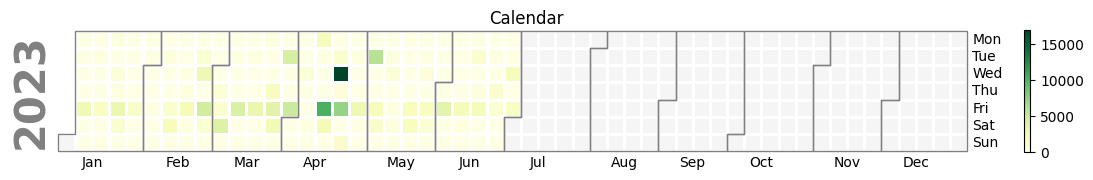

In [38]:
df = df.rename(columns={'FECHA': 'DAY'})
df = df.rename(columns={'UNID_FIQTY': 'VALUE'})
series = df.set_index('DAY')['VALUE']
# max_index = df['VALUE'].idxmax()
# max_value = df.loc[max_index, 'VALUE']
calplot.calplot(series, yearascending = False,colorbar = True,
                cmap = 'YlGn',
                suptitle = 'Calendar',
                yearlabel_kws={'fontname':'sans-serif'},
#                vmax=max_value
                )